<a href="https://colab.research.google.com/github/beverast/DS-Unit-1-Sprint-1-Dealing-With-Data/blob/master/module1-afirstlookatdata/LS_DS_111_A_First_Look_at_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - A First Look at Data



## Lecture - let's explore Python DS libraries and examples!

The Python Data Science ecosystem is huge. You've seen some of the big pieces - pandas, scikit-learn, matplotlib. What parts do you want to see more of?

In [0]:
# TODO - we'll be doing this live, taking requests
# and reproducing what it is to look up and learn things
# Making changes here!

## Assignment - now it's your turn

Pick at least one Python DS library, and using documentation/examples reproduce in this notebook something cool. It's OK if you don't fully understand it or get it 100% working, but do put in effort and look things up.

In [70]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Retrieve a CSV daataset over an API endpoint
# This dataset the LTC/USD exchange rate from the Bitfinex exchange
ltc_usd = pd.read_csv('https://www.quandl.com/api/v3/datasets/BITFINEX/LTCUSD.csv?api_key=4ZihQR6Zm2C7iNKK7t3z')
# Reverse the DataFrame so data appears in chronological order
ltc_usd = ltc_usd.reindex(index=ltc_usd.index[::-1])
# Check for NaN entries
ltc_usd.info();
ltc_usd.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1755 entries, 1754 to 0
Data columns (total 8 columns):
Date      1755 non-null object
High      1755 non-null float64
Low       1755 non-null float64
Mid       1755 non-null float64
Last      1755 non-null float64
Bid       1755 non-null float64
Ask       1755 non-null float64
Volume    1755 non-null float64
dtypes: float64(7), object(1)
memory usage: 109.8+ KB


,Date,High,Low,Mid,Last,Bid,Ask,Volume
1754,2014-04-15,13.18999,11.360200,13.03710,13.1399,12.9442,13.130,37885.001856
1753,2014-04-16,14.19990,12.580000,13.55000,13.6000,13.5000,13.600,45478.305420
1752,2014-04-17,13.75000,12.000000,12.80525,12.8400,12.7105,12.900,24619.725675
1751,2014-04-18,12.95000,11.750000,12.31960,12.2501,12.2502,12.389,24038.610676
1750,2014-04-19,13.24990,11.817111,12.92500,12.9900,12.9000,12.950,25058.421776


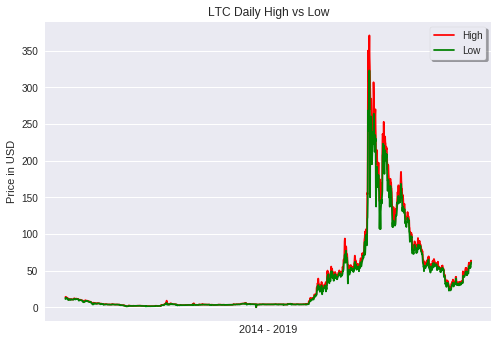

In [68]:
# Plot High and Low price data for all time
plt.plot_date(x=ltc_usd['Date'], y=ltc_usd['High'], fmt='-', color='r', markevery=5)
plt.plot_date(x=ltc_usd['Date'], y=ltc_usd['Low'], fmt='-', color='g', markevery=5)
#Format the graph
plt.xticks([])
plt.xlabel('2014 - 2019')
plt.ylabel('Price in USD')
plt.title('LTC Daily High vs Low')
plt.legend(frameon=True, shadow=True)

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  Describe in a paragraph of text what you did and why, as if you were writing an email to somebody interested but nontechnical.

First, I retrieved a dataset of Litecoin price information over the web from Quandl.com. I then checked it for missing values and got information on the "shape", or details, of the data. Next, I made a plot of the daily high and low trading prices for every day since the genesis block of Litecoin. I added color coding to each plot, labels to each axis,  a title, and a legend as well. 

2.  What was the most challenging part of what you did?

The most challenging aspect of making this chart was figuring out how to effectively plot time-series data. I tried a couple different methods but ultimately fell back on the easy-to-use pyplot.plot module.

3.  What was the most interesting thing you learned?

The most interesting thing that I learned was that working with date & time data can be laborious due to formatting naunces, but that matplotlib also has a date module like the Python standard library full of helper functions. 

4.  What area would you like to explore with more time?

Given more time I'd really like to look into seaborn's facilities for time-series plotting. Along with making plots that have more descriptive power like traditional stock plots for financial data, more interesting plots such as Ichimoku clouds would be good to explore.



## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub (and since this is the first assignment of the sprint, open a PR as well).

- [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)
- [scikit-learn documentation](http://scikit-learn.org/stable/documentation.html)
- [matplotlib documentation](https://matplotlib.org/contents.html)
- [Awesome Data Science](https://github.com/bulutyazilim/awesome-datascience) - a list of many types of DS resources

Stretch goals:

- Find and read blogs, walkthroughs, and other examples of people working through cool things with data science - and share with your classmates!
- Write a blog post (Medium is a popular place to publish) introducing yourself as somebody learning data science, and talking about what you've learned already and what you're excited to learn more about.